In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.bp as bp
import pyeit.eit.greit as greit
import pyeit.eit.jac as jac
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
import tensorflow as tf
from pyeit.eit.interp2d import sim2pts
from sciopy import norm_data
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from support import GREIT_sample, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    Add,
    BatchNormalization,
    Bidirectional,
    Concatenate,
    Conv1D,
    Conv2D,
    ConvLSTM1D,
    Cropping1D,
    Cropping2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    MaxPooling1D,
    Normalization,
    Reshape,
    ZeroPadding1D,
)
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model

2023-10-23 14:36:44.135858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# VAE & LSTM V2 for n_el=16

### Build VAE

In [2]:
n_el = 16
r_obj = 0.3
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_30 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_30):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [3]:
n_el = 16
r_obj = 0.35
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_35 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_35):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [4]:
n_el = 16
r_obj = 0.4
h0 = 0.025
dist_exc = 8
step_meas = 4

load_path_40 = f"../data/{h0=}_{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path_40):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [5]:
V_30 = np.load(
    "../saves/" + load_path_30.split("/")[2] + "_v_data.npy", allow_pickle=True
)[::1]
V_35 = np.load(
    "../saves/" + load_path_35.split("/")[2] + "_v_data.npy", allow_pickle=True
)[::1]
V_40 = np.load(
    "../saves/" + load_path_40.split("/")[2] + "_v_data.npy", allow_pickle=True
)[::1]

In [6]:
print(V_30.shape)
print(V_35.shape)
print(V_40.shape)

(999, 192)
(999, 192)
(999, 192)


In [7]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = keras.backend.random_normal(
        shape=(keras.backend.shape(z_mean)[0], latent_dim)
    )
    return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

In [8]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(192,))

x = layers.Dense(64, activation="relu")(encoder_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           12352       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32)           2080        ['dense[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 32)           0           ['dense_1[0][0]']                
                                                                                            

2023-10-23 14:36:53.899293: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46672 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-10-23 14:36:53.901198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46672 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [9]:
# Definiere den Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(192, activation="relu")(x)
decoder_outputs = layers.Flatten()(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                80        
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dense_6 (Dense)             (None, 192)               12480     
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                                 
Total params: 15,216
Trainable params: 15,216
Non-trainable

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(mse_loss)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [12]:
V_all = np.concatenate((V_30, V_35, V_40))

<StemContainer object of 3 artists>

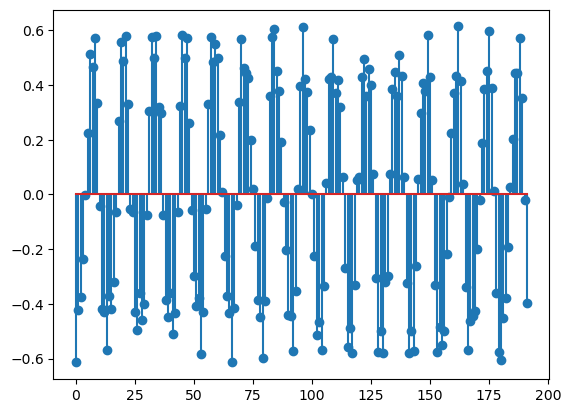

In [13]:
plt.stem(V_all[100, :])

In [14]:
V_vae_train, V_vae_test = train_test_split(
    V_all, test_size=0.05, shuffle=True, random_state=52
)

In [15]:
print(V_vae_train.shape, V_vae_test.shape)

(2847, 192) (150, 192)


In [16]:
history = vae.fit(V_vae_train, epochs=50, batch_size=64)

Epoch 1/50


2023-10-23 14:36:56.965312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-23 14:36:57.015533: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5581c0a0b710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-23 14:36:57.015580: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-23 14:36:57.015593: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-23 14:36:57.042753: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-23 14:36:57.190342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-23 14:36:57.35443

45/45 [==============================] - 4s 6ms/step - loss: 0.1512 - reconstruction_loss: 0.1111 - kl_loss: 0.0068
Epoch 2/50
45/45 [==============================] - 0s 6ms/step - loss: 0.0869 - reconstruction_loss: 0.0855 - kl_loss: 6.0818e-05
Epoch 3/50
45/45 [==============================] - 0s 6ms/step - loss: 0.0829 - reconstruction_loss: 0.0823 - kl_loss: 2.0173e-05
Epoch 4/50
45/45 [==============================] - 0s 6ms/step - loss: 0.0814 - reconstruction_loss: 0.0812 - kl_loss: 7.7086e-06
Epoch 5/50
45/45 [==============================] - 0s 6ms/step - loss: 0.0812 - reconstruction_loss: 0.0810 - kl_loss: 2.8795e-06
Epoch 6/50
45/45 [==============================] - 0s 6ms/step - loss: 0.0808 - reconstruction_loss: 0.0809 - kl_loss: 1.4479e-06
Epoch 7/50
45/45 [==============================] - 0s 6ms/step - loss: 0.0809 - reconstruction_loss: 0.0808 - kl_loss: 1.0101e-06
Epoch 8/50
45/45 [==============================] - 0s 6ms/step - loss: 0.0808 - reconstruction_lo

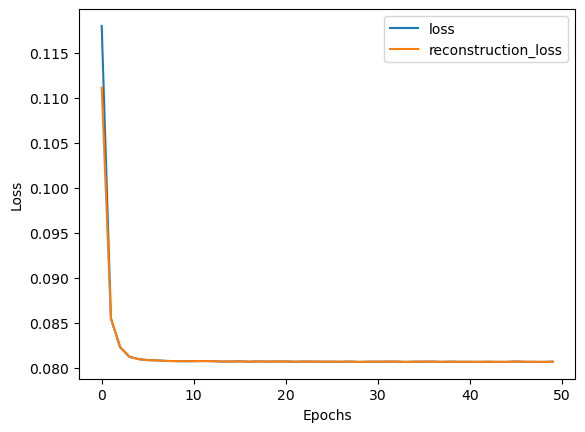

In [17]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [47]:
z_mean, z_log_var, latent_data = vae.encoder.predict(V_40[::5])

7/7 [==============================] - 0s 1ms/step


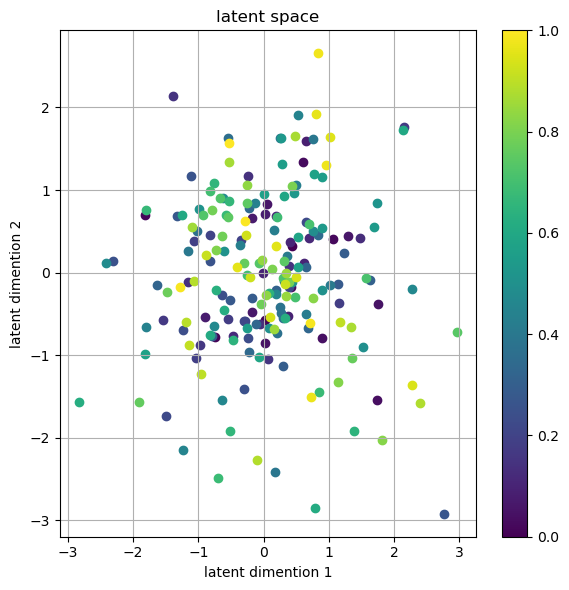

In [48]:
# Perform t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2)
latent_space_2d = tsne.fit_transform(latent_data)

plt.figure(figsize=(6, 6))

plt.title("latent space")
colors = plt.cm.viridis(np.linspace(0, 1, latent_data.shape[0]))

for i, ele in enumerate(latent_data):
    plt.scatter(ele[0], ele[1], color=colors[i])
plt.xlabel("latent dimention 1")
plt.ylabel("latent dimention 2")
plt.colorbar()
plt.grid()
plt.tight_layout()
plt.show()

### Build LSTM

In [49]:
V_z_mean_30, V_z_log_var_30, V_z_30 = vae.encoder.predict(V_30)
V_z_mean_35, V_z_log_var_35, V_z_35 = vae.encoder.predict(V_35)
V_z_mean_40, V_z_log_var_40, V_z_40 = vae.encoder.predict(V_40)

32/32 [==============================] - 0s 806us/step


In [22]:
# creates overlapping segments with a length of nseg
nseg = 4

X0_30 = [V_z_30[n : n + nseg, :] for n in range(V_z_30.shape[0] - nseg + 1)]
X0_30 = np.array(X0_30)

X0_35 = [V_z_35[n : n + nseg, :] for n in range(V_z_35.shape[0] - nseg + 1)]
X0_35 = np.array(X0_35)

X0_40 = [V_z_40[n : n + nseg, :] for n in range(V_z_40.shape[0] - nseg + 1)]
X0_40 = np.array(X0_40)

Y0_30 = np.array(V_z_30[nseg - 1 :])
Y0_35 = np.array(V_z_35[nseg - 1 :])
Y0_40 = np.array(V_z_40[nseg - 1 :])

In [23]:
print(X0_30.shape, Y0_30.shape)
print(X0_35.shape, Y0_35.shape)
print(X0_40.shape, Y0_40.shape)

(497, 4, 4) (497, 4)
(497, 4, 4) (497, 4)
(497, 4, 4) (497, 4)


In [24]:
X0_30_35_40 = np.concatenate((X0_30, X0_35, X0_40))
Y0_30_35_40 = np.concatenate((Y0_30, Y0_35, Y0_40))
print(X0_30_35_40.shape, Y0_30_35_40.shape)

(1491, 4, 4) (1491, 4)


In [25]:
X_lstm_train, X_lstm_test, Y_lstm_train, Y_lstm_test = train_test_split(
    X0_30_35_40, Y0_30_35_40, test_size=0.05, shuffle=True, random_state=52
)

In [26]:
print(X_lstm_train.shape, Y_lstm_train.shape)
print(X_lstm_test.shape, Y_lstm_test.shape)

(1416, 4, 4) (1416, 4)
(75, 4, 4) (75, 4)


In [27]:
def lstm_split(input_shape, nseg, v_shape):
    def Slice(s):
        # function for slicing x
        def func(x):
            return x[:, s, :]

        return func

    # define shared layers
    dense = Dense(v_shape, activation="relu")
    inputs = Input(shape=input_shape)
    con_list = []
    for s in range(nseg):
        # slicing x
        x = Lambda(Slice(s))(inputs)
        # shared layers
        x = dense(x)
        con_list.append(x)

    # concat and reshape for LSTM
    x = Concatenate(axis=1)(con_list)
    x = Reshape((nseg, int(x.shape[1] / nseg)))(x)

    x = LSTM(v_shape)(x)
    x = Activation("softmax")(x)

    return Model(inputs, x)

In [28]:
model = lstm_split(
    input_shape=(nseg, latent_dim), nseg=nseg, v_shape=Y0_30_35_40.shape[1]
)
model.compile(optimizer="adam", loss="MeanSquaredError")
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4, 4)]       0           []                               
                                                                                                  
 lambda (Lambda)                (None, 4)            0           ['input_2[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 4)            0           ['input_2[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 4)            0           ['input_2[0][0]']                
                                                                                              

2023-10-23 14:21:33.082621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-23 14:21:33.083911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-23 14:21:33.084801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [29]:
epochs = 100
batch_size = 8

history = model.fit(
    X_lstm_train,
    Y_lstm_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_lstm_test, Y_lstm_test),
)

Epoch 1/100


2023-10-23 14:21:33.414838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-23 14:21:33.416272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-23 14:21:33.417347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

177/177 [==============================] - 3s 7ms/step - loss: 1.0830 - val_loss: 1.1058
Epoch 2/100
  1/177 [..............................] - ETA: 0s - loss: 1.0078

2023-10-23 14:21:36.046984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-23 14:21:36.048246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-23 14:21:36.049527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

177/177 [==============================] - 1s 5ms/step - loss: 1.0606 - val_loss: 1.0831
Epoch 3/100
177/177 [==============================] - 1s 5ms/step - loss: 1.0379 - val_loss: 1.0615
Epoch 4/100
177/177 [==============================] - 1s 5ms/step - loss: 1.0155 - val_loss: 1.0384
Epoch 5/100
177/177 [==============================] - 1s 5ms/step - loss: 0.9921 - val_loss: 1.0108
Epoch 6/100
177/177 [==============================] - 1s 5ms/step - loss: 0.9678 - val_loss: 0.9841
Epoch 7/100
177/177 [==============================] - 1s 5ms/step - loss: 0.9489 - val_loss: 0.9687
Epoch 8/100
177/177 [==============================] - 1s 5ms/step - loss: 0.9375 - val_loss: 0.9598
Epoch 9/100
177/177 [==============================] - 1s 5ms/step - loss: 0.9303 - val_loss: 0.9539
Epoch 10/100
177/177 [==============================] - 1s 5ms/step - loss: 0.9254 - val_loss: 0.9499
Epoch 11/100
177/177 [==============================] - 1s 5ms/step - loss: 0.9218 - val_loss: 0.9467


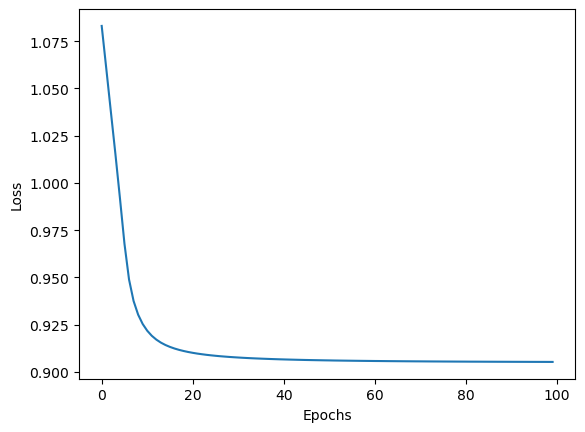

In [30]:
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [31]:
# 1. Vae -> komprimieren der nsegs
# 2. lstm vorhersage

In [32]:
pred_40 = model.predict(X0_40)

16/16 [==============================] - 0s 2ms/step


2023-10-23 14:23:03.721072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-23 14:23:03.722603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-23 14:23:03.723689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [33]:
V_dec_40 = np.array(vae.decoder(pred_40))

<StemContainer object of 3 artists>

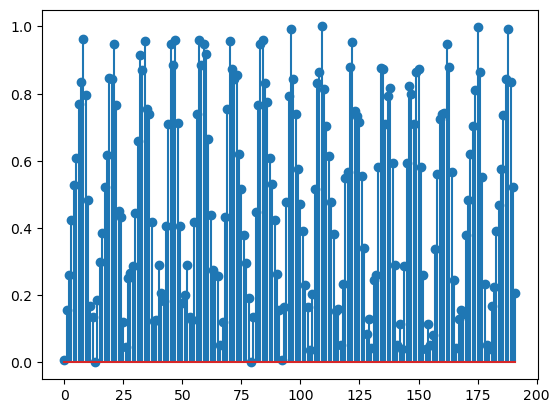

In [49]:
plt.stem(norm_data(V_40[14, :]))

<StemContainer object of 3 artists>

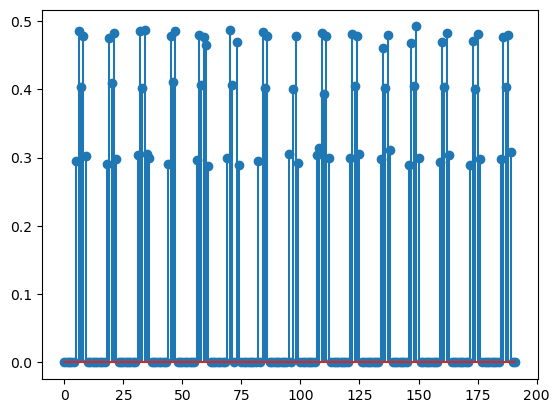

In [50]:
plt.stem(V_dec_40[14, :])

In [36]:
tmp = np.load(load_path_40 + "sample_000014.npz", allow_pickle=True)

<StemContainer object of 3 artists>

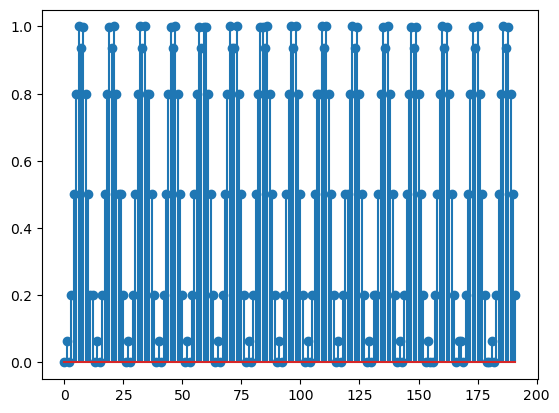

In [59]:
plt.stem(norm_data(tmp["v_empty"]))

<StemContainer object of 3 artists>

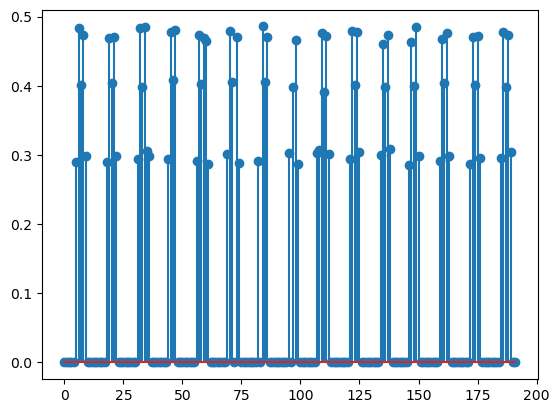

In [58]:
plt.stem(V_dec_40[10, :])

In [60]:
tmp_s = {
    "anomaly": tmp["anomaly"],
    "perm_array": tmp["perm_array"],
    "n_el": tmp["n_el"],
    "h0": tmp["h0"],
    "v_empty": norm_data(tmp["v_empty"]),
    "v_obj": V_dec_40[14, :],
    "dist_exc": tmp["dist_exc"],
    "step_meas": tmp["step_meas"],
}

/home/jath/.conda/envs/TF2_12/lib/python3.11/site-packages/pyeit/eit/base.py:188: RuntimeWarning: invalid value encountered in divide
  return (v1 - v0) / np.abs(v0)


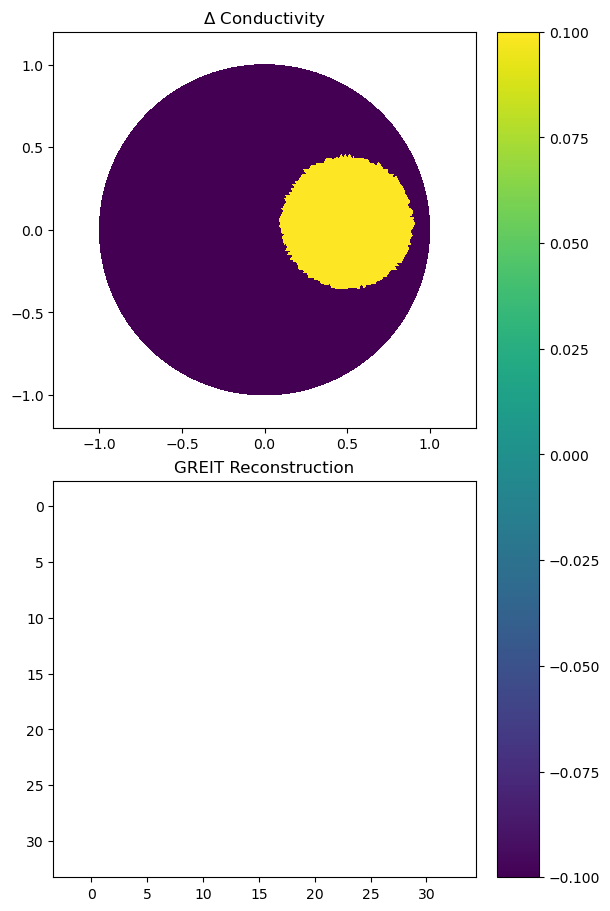

In [61]:
GREIT_sample(tmp_s, rec_only=False)

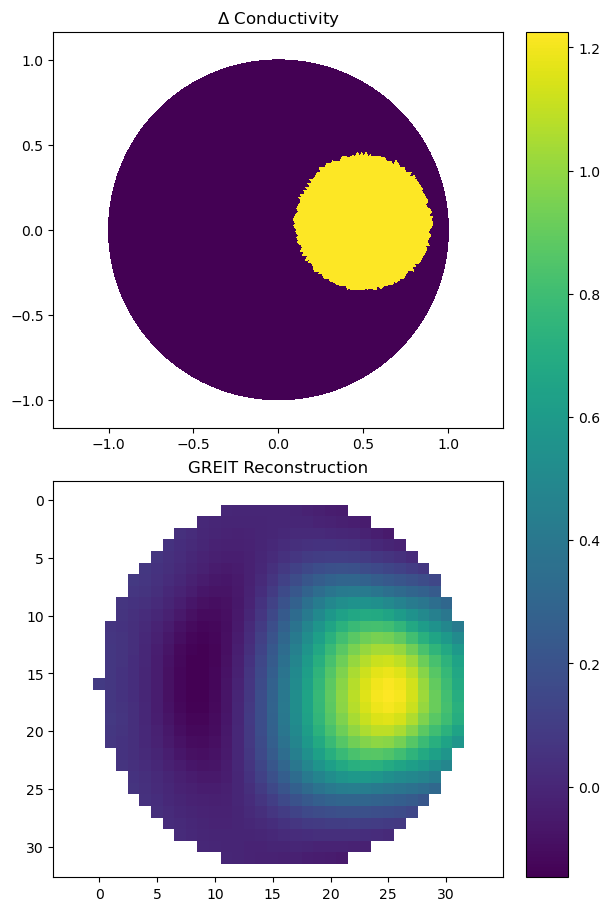

In [62]:
GREIT_sample(tmp, rec_only=False)